In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader
import torch.nn as nn
from timeit import Timer
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame as df
import numpy as np

In [40]:
df = pd.read_csv("/kaggle/input/geoelectric-models/geoelectric_models.csv")

X_raw = df[[f'dBzdt_{i}' for i in range(1, 41)]].values
y_raw = df[[f'rho_{i}' for i in range(1, 21)] + [f'thk_{i}' for i in range(1, 20)]].values

X = -np.log10(X_raw)
y = np.log10(y_raw)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)




# -np.log10(X_raw),X_raw

(array([[ 9.69982206,  9.94458726, 10.19018853, ..., 11.88630059,
         11.99007767, 12.07946189],
        [ 9.02043478,  9.26447695,  9.50945583, ..., 11.4042272 ,
         11.6420823 , 11.87807265],
        [10.02485092, 10.27050313, 10.51810325, ..., 11.8835882 ,
         11.9661261 , 12.05357918],
        ...,
        [ 9.7571084 , 10.00190508, 10.24765188, ..., 11.89287486,
         11.98805758, 12.07396589],
        [ 9.9041022 , 10.14915412, 10.39569617, ..., 11.8929088 ,
         11.97652942, 12.06072941],
        [ 9.13455903,  9.37879255,  9.62392332, ..., 11.51990678,
         11.75032235, 11.96836132]]),
 array([[1.99608e-10, 1.13609e-10, 6.45374e-11, ..., 1.29927e-12,
         1.02311e-12, 8.32795e-13],
        [9.54037e-10, 5.43905e-10, 3.09417e-10, ..., 3.94251e-12,
         2.27991e-12, 1.32412e-12],
        [9.44385e-11, 5.36410e-11, 3.03317e-11, ..., 1.30741e-12,
         1.08112e-12, 8.83936e-13],
        ...,
        [1.74941e-10, 9.95623e-11, 5.65390e-11, ..., 1

In [ ]:
class NLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(40, 80),
            nn.ReLU(),
            nn.Linear(80, 40),
            nn.ReLU(),
            nn.Linear(40, 39)
        )
    
    def forward(self, x):
        return self.layers(x)

model = NLP()
def train_model(model,EPOCHS = 100):
    # EPOCHS = 100
    for epoch in range(EPOCHS):
        model.train()
        y_pred = model(X_train_t)
        loss = loss_fn(y_pred, y_train_t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch  % 1000 == 0 :
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
train_model(model, EPOCHS=10000)

Epoch 0: Loss = 380.196655
Epoch 1000: Loss = 380.196655
Epoch 2000: Loss = 380.196655
Epoch 3000: Loss = 380.196655
Epoch 4000: Loss = 380.196655
Epoch 5000: Loss = 380.196655
Epoch 6000: Loss = 380.196655
Epoch 7000: Loss = 380.196655
Epoch 8000: Loss = 380.196655
Epoch 9000: Loss = 380.196655


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, skip=True):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.skip = skip
        if skip and in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.skip:
            out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_proj = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.layer1 = ResNetBlock(16, 32, skip=True)
        self.layer2 = ResNetBlock(32, 32, skip=True)
        self.layer3 = ResNetBlock(32, 64, skip=True)
        self.layer4 = ResNetBlock(64, 64, skip=True)
        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 39)

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.input_proj(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.dropout(x)
        x = self.global_pool(x).squeeze(-1) 
        x = self.fc(x) 
        return x

model = ResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

summary(model, input_size=(40,))


In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_t = X_train_t.to(device)
y_train_t = y_train_t.to(device)
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

for epoch in range(501):
    model.train()
    y_pred = model(X_train_t)
    loss = loss_fn(y_pred, y_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_t)
        loss_test = loss_fn(y_pred_test, y_test_t)
        y_test_np = y_test_t.cpu().numpy()
        y_pred_np = y_pred_test.cpu().numpy()
        mae = mean_absolute_error(y_test_np, y_pred_np)
        rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
        r2 = r2_score(y_test_np, y_pred_np)

    if epoch % 50 == 0:
        print(f"epoch:{epoch} | loss_train: {loss.item():.4f} | loss_test: {loss_test.item():.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")


In [3]:
import torch
import torch.nn as nn

class GPRNet(nn.Module):
    def __init__(self, in_channels=1, input_length=1200, neurons=8, kernel_size=30, enable_dropout=False, dp_coeff=0.2):
        super(GPRNet, self).__init__()
        D = dp_coeff if enable_dropout else 0.0

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, neurons, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(D)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(neurons, neurons*2, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(D)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(neurons*2, neurons*4, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(D)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(neurons*4, neurons*8, kernel_size, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(D)
        )

        self.py1 = nn.Sequential(
            nn.Conv1d(neurons*8, neurons*16, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Dropout(D)
        )

        self.py2 = nn.Sequential(
            nn.Conv1d(neurons*8, neurons*16, kernel_size, padding='same', dilation=6),
            nn.ReLU(),
            nn.Dropout(D)
        )

        self.py3 = nn.Sequential(
            nn.Conv1d(neurons*8, neurons*16, kernel_size, padding='same', dilation=12),
            nn.ReLU(),
            nn.Dropout(D)
        )

        self.py4 = nn.Sequential(
            nn.Conv1d(neurons*8, neurons*16, kernel_size, padding='same', dilation=18),
            nn.ReLU(),
            nn.Dropout(D)
        )

        self.merge1_conv = nn.Sequential(
            nn.Conv1d(neurons*16*4 + neurons*8, neurons*16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(D)
        )

        self.upmgconv = nn.Sequential(
            nn.Upsample(scale_factor=4, mode='nearest'),
            nn.Dropout(D)
        )

        self.deconv1 = nn.Sequential(
            nn.Conv1d(neurons*8, neurons*16, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Dropout(D)
        )

        self.deconv2 = nn.Sequential(
            nn.Conv1d(neurons*16, neurons*8, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Dropout(D)
        )

        self.deconv3 = nn.Sequential(
            nn.Conv1d(neurons*16 + neurons*8, neurons*4, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Dropout(D)
        )

        self.deconv4 = nn.Sequential(
            nn.Conv1d(neurons*4, neurons*2, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Dropout(D)
        )

        self.deconv5 = nn.Sequential(
            nn.Conv1d(neurons*2, 1, kernel_size, padding='same'),
            nn.ReLU(),
            nn.Dropout(D)  
        )
        self.output_pool = nn.AdaptiveAvgPool1d(39)
        # self.flatten =nn.Flatten()
        # self.linear = nn.Linear(32,39)

    def forward(self, x):
        x1 = self.conv1(x)  # 600
        x2 = self.conv2(x1)  # 300
        x3 = self.conv3(x2)  # 150
        x4 = self.conv4(x3)  # 75

        py1 = self.py1(x4)
        py2 = self.py2(x4)
        py3 = self.py3(x4)
        py4 = self.py4(x4)

        merged = torch.cat([py1, py2, py3, py4, x4], dim=1)
        merged = self.merge1_conv(merged)
        upmg = self.upmgconv(merged)

        d1 = self.deconv1(x4)
        d2 = self.deconv2(d1)

        merged2 = torch.cat([upmg, d2], dim=1)
        d3 = self.deconv3(merged2)
        d4 = self.deconv4(d3)
        out = self.deconv5(d4)
        out = self.deconv5(d4)          
        out = self.output_pool(out)
        out = out.squeeze(1)
        # out = self.linear(self.flatten(out))
        return out


In [ ]:
# !pip install torchsummary
device = "cuda"
from torchsummary import summary
model_gpr = GPRNet().to(device)
summary(model_gpr, input_size=(1, 40)) 

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

def R2_score(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + 1e-8)

def train_gpr_model(X, y, epochs=1001, lr=1e-3, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GPRNet().to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val)
            r2_train = R2_score(y_train, preds)

        if epoch % 50 == 0:
            print(f"Epoch {epoch:03} | Train Loss: {loss.item():.4f} | R² Train: {r2_train.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # scheduler.step(val_loss)
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model

def evaluate(model, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device
    X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(X_test_t)

    y_real = 10 ** y_test_t
    preds_real = 10 ** preds

    mae = mean_absolute_error(y_real.cpu(), preds_real.cpu())
    rmse = mean_squared_error(y_real.cpu(), preds_real.cpu(), squared=False)
    r2 = R2_score(y_real, preds_real)

    print("\n--- Final Evaluation ---")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2.item():.4f}")

X_raw = df[[f'dBzdt_{i}' for i in range(1, 41)]].values
y_raw = df[[f'rho_{i}' for i in range(1, 21)] + [f'thk_{i}' for i in range(1, 20)]].values

X = np.log10(np.clip(X_raw, 1e-8, None))
y = np.log10(np.clip(y_raw, 1e-8, None))

model = train_gpr_model(X, y, epochs=1001)
evaluate(model, X, y)


Using 2 GPUs
Epoch 000 | Train Loss: 6.0900 | R² Train: -30.6048 | Val Loss: 6.0655
Epoch 050 | Train Loss: 0.1916 | R² Train: 0.0056 | Val Loss: 0.1840
Epoch 100 | Train Loss: 0.1716 | R² Train: 0.1093 | Val Loss: 0.1743
Epoch 150 | Train Loss: 0.1707 | R² Train: 0.1139 | Val Loss: 0.1733
Epoch 250 | Train Loss: 0.1701 | R² Train: 0.1173 | Val Loss: 0.1726
Epoch 300 | Train Loss: 0.1699 | R² Train: 0.1184 | Val Loss: 0.1724
Epoch 350 | Train Loss: 0.1697 | R² Train: 0.1192 | Val Loss: 0.1722
Epoch 400 | Train Loss: 0.1696 | R² Train: 0.1199 | Val Loss: 0.1720
Epoch 450 | Train Loss: 0.1695 | R² Train: 0.1205 | Val Loss: 0.1719
Epoch 500 | Train Loss: 0.1694 | R² Train: 0.1211 | Val Loss: 0.1718
Epoch 550 | Train Loss: 0.1693 | R² Train: 0.1216 | Val Loss: 0.1716
Epoch 600 | Train Loss: 0.1691 | R² Train: 0.1222 | Val Loss: 0.1715
Epoch 650 | Train Loss: 0.1690 | R² Train: 0.1229 | Val Loss: 0.1714
Epoch 700 | Train Loss: 0.1689 | R² Train: 0.1235 | Val Loss: 0.1712
Epoch 750 | Train L

In [ ]:
# Using 2 GPUs
# Epoch 000 | Train Loss: 6.2867 | R² Train: -31.6256 | Val Loss: 6.2698
# Epoch 050 | Train Loss: 0.2599 | R² Train: -0.3488 | Val Loss: 0.2451
# Epoch 100 | Train Loss: 0.1693 | R² Train: 0.1214 | Val Loss: 0.1718
# Epoch 150 | Train Loss: 0.1690 | R² Train: 0.1227 | Val Loss: 0.1715
# Epoch 200 | Train Loss: 0.1690 | R² Train: 0.1227 | Val Loss: 0.1715
# Epoch 250 | Train Loss: 0.1690 | R² Train: 0.1227 | Val Loss: 0.1715
# Epoch 300 | Train Loss: 0.1690 | R² Train: 0.1227 | Val Loss: 0.1715
# Epoch 350 | Train Loss: 0.1690 | R² Train: 0.1227 | Val Loss: 0.1715
# Epoch 400 | Train Loss: 0.1690 | R² Train: 0.1227 | Val Loss: 0.1715
# Epoch 450 | Train Loss: 0.1690 | R² Train: 0.1227 | Val Loss: 0.1715

# --- Final Evaluation ---
# MAE:  199.7135
# RMSE: 236.5975
# R²:   0.0872

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GPRNet(nn.Module):
    def __init__(self, in_channels=1, input_length=40, neurons=8, kernel_size=5, enable_dropout=True, dp_coeff=0.3):
        super(GPRNet, self).__init__()
        self.input_length = input_length
        D = dp_coeff if enable_dropout else 0.0

        # Encoder with proper padding and batch normalization
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, neurons, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(neurons),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(D)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(neurons, neurons*2, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(neurons*2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(D)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(neurons*2, neurons*4, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(neurons*4),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(D)
        )

        # Pyramid pooling with smaller dilations for short sequences
        self.py1 = nn.Sequential(
            nn.Conv1d(neurons*4, neurons*8, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(neurons*8),
            nn.ReLU(),
            nn.Dropout(D)
        )

        self.py2 = nn.Sequential(
            nn.Conv1d(neurons*4, neurons*8, kernel_size, padding=kernel_size//2, dilation=2),
            nn.BatchNorm1d(neurons*8),
            nn.ReLU(),
            nn.Dropout(D)
        )

        self.py3 = nn.Sequential(
            nn.Conv1d(neurons*4, neurons*8, kernel_size, padding=kernel_size//2, dilation=3),
            nn.BatchNorm1d(neurons*8),
            nn.ReLU(),
            nn.Dropout(D)
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Conv1d(neurons*8*3 + neurons*4, neurons*8, kernel_size=3, padding=1),
            nn.BatchNorm1d(neurons*8),
            nn.ReLU(),
            nn.Dropout(D)
        )

        # Decoder
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose1d(neurons*8, neurons*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(neurons*4),
            nn.ReLU(),
            nn.Dropout(D)
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose1d(neurons*4, neurons*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(neurons*2),
            nn.ReLU(),
            nn.Dropout(D)
        )

        self.deconv3 = nn.Sequential(
            nn.ConvTranspose1d(neurons*2, neurons, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(neurons),
            nn.ReLU(),
            nn.Dropout(D)
        )

        # Final output layer
        self.final_conv = nn.Conv1d(neurons, 1, kernel_size=3, padding=1)
        
        # Adaptive pooling to get exactly 39 outputs
        self.output_pool = nn.AdaptiveAvgPool1d(39)

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)    # [B, neurons, L/2]
        x2 = self.conv2(x1)   # [B, neurons*2, L/4]
        x3 = self.conv3(x2)   # [B, neurons*4, L/8]

        # Pyramid pooling
        py1 = self.py1(x3)
        py2 = self.py2(x3)
        py3 = self.py3(x3)

        # Concatenate pyramid features with original
        fused = torch.cat([py1, py2, py3, x3], dim=1)
        fused = self.fusion(fused)

        # Decoder
        d1 = self.deconv1(fused)
        d2 = self.deconv2(d1)
        d3 = self.deconv3(d2)

        # Final output
        out = self.final_conv(d3)
        out = self.output_pool(out)
        out = out.squeeze(1)  # Remove channel dimension
        
        return out

# Improved training function
def train_gpr_model(X, y, epochs=1000, lr=1e-3, batch_size=64, patience=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create model
    model = GPRNet(input_length=X.shape[1]).to(device)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    
    # Data preparation
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
    
    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, factor=0.5, verbose=True
    )
    
    # Early stopping
    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val)
            
            # Calculate R²
            r2_train = R2_score(y_train, preds)
            r2_val = R2_score(y_val, val_preds)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 50 == 0:
            print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | R² Train: {r2_train.item():.4f} | "
                  f"Val Loss: {val_loss.item():.4f} | R² Val: {r2_val.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Load best model
    model.load_state_dict(best_model)
    return model

def R2_score(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + 1e-8)

# Updated evaluation function
def evaluate(model, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device
    
    X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        preds = model(X_test_t)
    
    # Convert back from log space
    y_real = 10 ** y_test_t
    preds_real = 10 ** preds
    
    # Calculate metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(y_real.cpu(), preds_real.cpu())
    rmse = mean_squared_error(y_real.cpu(), preds_real.cpu(), squared=False)
    r2 = R2_score(y_real, preds_real)
    
    print("\n--- Final Evaluation ---")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2.item():.4f}")
    
    return mae, rmse, r2.item()

# Usage example:
X_raw = df[[f'dBzdt_{i}' for i in range(1, 41)]].values
y_raw = df[[f'rho_{i}' for i in range(1, 21)] + [f'thk_{i}' for i in range(1, 20)]].values
X = np.log10(np.clip(X_raw, 1e-8, None))
y = np.log10(np.clip(y_raw, 1e-8, None))
model = train_gpr_model(X, y, epochs=1000)
evaluate(model, X, y)

In [16]:
def predict_and_print(model, X_new, y_true):
    model.eval()
    device = next(model.parameters()).device
    X_new_t = torch.tensor(X_new, dtype=torch.float32).unsqueeze(1).to(device)

    with torch.no_grad():
        preds = model(X_new_t)

    preds_real = 10 ** preds.cpu().numpy()
    y_true_real = 10 ** y_true

    print("\n--- Predictions ---")
    for i, pred in enumerate(preds_real):
        print(f"Sample {i + 1:02}: Predicted = {pred}")

    print("\n--- Actual Values ---")
    for i, real in enumerate(y_true_real):
        print(f"Sample {i + 1:02}: Actual    = {real}")
X_sample = X[:1]
y_sample = y[:1] 

predict_and_print(model, X_sample, y_sample)



--- Predictions ---
Sample 01: Predicted = [390.8203  388.84607 392.226   392.63986 391.0508  394.43216 375.718
 394.07092 387.7555  379.471   394.23947 374.00888 390.39273 381.76465
 377.97546 392.43796 385.55432 376.78815 401.1394  356.44373 212.52766
 177.23723 202.1991  195.2486  195.22073 192.94225 189.5548  195.10587
 186.87282 190.75308 197.61537 192.7064  192.7827  192.24898 188.33403
 196.11768 195.32622 186.16331 189.36841]

--- Actual Values ---
Sample 01: Actual    = [446.343  446.343  446.343  446.343  446.343  446.343  446.343  446.343
 446.343  446.343  509.278  509.278  509.278  509.278  509.278  509.278
 509.278  509.278  509.278  509.278  266.184  430.139  339.507  403.307
 266.559  478.036   35.2051 271.676  142.267  241.488  343.062  105.713
 304.864  164.436  440.662   68.4305  52.9991 479.64    78.1452]


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

class EncoderBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, dropout_rate=0.3):
        super(EncoderBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.dropout(out)
        return out


class AttentionBlock(nn.Module):
    
    def __init__(self, hidden_dim):
        super(AttentionBlock, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.query = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.key = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.value = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.scale = hidden_dim ** -0.5
        
    def forward(self, x):
        batch_size, channels, seq_len = x.size()
        
        # Generate queries, keys, and values
        q = self.query(x).view(batch_size, channels, seq_len)
        k = self.key(x).view(batch_size, channels, seq_len)
        v = self.value(x).view(batch_size, channels, seq_len)
        
        # Compute attention scores
        attention = torch.matmul(q.transpose(-2, -1), k) * self.scale
        attention = F.softmax(attention, dim=-1)
        
        # Apply attention to values
        out = torch.matmul(v, attention.transpose(-2, -1))
        
        return out + x  # Residual connection


class MultiScaleBlock(nn.Module):
    
    def __init__(self, hidden_dim):
        super(MultiScaleBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.bn5 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x):
        out1 = F.relu(self.bn1(self.conv1(x)))
        out3 = F.relu(self.bn3(self.conv3(x)))
        out5 = F.relu(self.bn5(self.conv5(x)))
        
        return torch.cat([out1, out3, out5], dim=1)


class GPRNet(nn.Module):
    def __init__(self, input_size=40, output_size=39, hidden_dim=64, num_layers=4, 
                 dropout_rate=0.3, use_attention=True):
        super(GPRNet, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.use_attention = use_attention
        
        # Input projection
        self.input_proj = nn.Conv1d(1, hidden_dim, kernel_size=3, padding=1)
        self.encoder_blocks = nn.ModuleList()
        for i in range(num_layers):
            self.encoder_blocks.append(
                EncoderBlock(hidden_dim, hidden_dim, dropout_rate)
            )
        
        # Attention mechanism
        if use_attention:
            self.attention = AttentionBlock(hidden_dim)
        
        # Feature extraction with multiple scales
        self.multi_scale = MultiScaleBlock(hidden_dim)
        
        # Decoder with progressive upsampling
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden_dim * 3, hidden_dim * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Conv1d(hidden_dim * 2, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Conv1d(hidden_dim, hidden_dim // 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        
        # Output projection with exact size mapping
        self.output_proj = nn.Conv1d(hidden_dim // 2, 1, kernel_size=2, padding=0)
        
        # Ensure exact output size
        self.size_adjust = nn.Linear(input_size - 1, output_size)
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Conv1d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, 0, 0.01)
            nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        x = self.input_proj(x)
        residual = x
        for block in self.encoder_blocks:
            x = block(x)
            x = x + residual  # Residual connection
            residual = x
        
        # Apply attention if enabled
        if self.use_attention:
            x = self.attention(x)
        
        # Multi-scale feature extraction
        x = self.multi_scale(x)
        
        # Decode
        x = self.decoder(x)
        
        # Output projection
        x = self.output_proj(x)  
        x = x.squeeze(1)  
        x = self.size_adjust(x)  
        
        return x


def calculate_r2(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + 1e-8)


def train_model(model, X_train, y_train, X_val, y_val, epochs=1000, batch_size=32, 
                learning_rate=1e-3, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_train_tensor = X_train.unsqueeze(1).to(device)
    y_train_tensor = y_train.to(device)
    X_val_tensor = X_val.unsqueeze(1).to(device)
    y_val_tensor = y_val.to(device)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=25, factor=0.5, verbose=verbose
    )
    
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    train_r2_scores = []
    val_r2_scores = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_predictions.append(outputs.detach())
            train_targets.append(batch_y.detach())
        
        train_loss /= len(train_loader)
        train_pred = torch.cat(train_predictions)
        train_target = torch.cat(train_targets)
        train_r2 = calculate_r2(train_target, train_pred)
        
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor).item()
            val_r2 = calculate_r2(y_val_tensor, val_pred)
        
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2_scores.append(train_r2.item())
        val_r2_scores.append(val_r2.item())
        
        if verbose and (epoch + 1) % 50 == 0 or epoch:
            print(f"Epoch {epoch+1:4d}/{epochs} | "
                  f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
                  f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    if verbose:
        print("Training completed.")
    
    return train_losses, val_losses, train_r2_scores, val_r2_scores


def evaluate_model(model, X_test, y_test, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_tensor = X_test.unsqueeze(1).to(device)
    y_test_tensor = y_test.to(device)

    with torch.no_grad():
        predictions = model(X_test_tensor)
 
    y_pred = predictions.cpu().numpy()
    y_true = y_test.cpu().numpy()
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    output_r2 = []
    for i in range(y_true.shape[1]):
        output_r2.append(r2_score(y_true[:, i], y_pred[:, i]))
    
    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'output_r2': output_r2,
        'predictions': y_pred,
        'true_values': y_true
    }
    
    if verbose:
        print("\n" + "="*50)
        print("MODEL EVALUATION RESULTS")
        print("="*50)
        print(f"Mean Squared Error (MSE):  {mse:.6f}")
        print(f"Root Mean Squared Error:   {rmse:.6f}")
        print(f"Mean Absolute Error:       {mae:.6f}")
        print(f"R² Score:                  {r2:.4f}")
        print(f"Mean Per-Output R²:        {np.mean(output_r2):.4f}")
        print(f"Std Per-Output R²:         {np.std(output_r2):.4f}")
        print("="*50)
    
    return metrics


def plot_training_history(train_losses, val_losses, train_r2_scores, val_r2_scores):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(train_losses, label='Training Loss', alpha=0.7)
    axes[0].plot(val_losses, label='Validation Loss', alpha=0.7)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(train_r2_scores, label='Training R²', alpha=0.7)
    axes[1].plot(val_r2_scores, label='Validation R²', alpha=0.7)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('R² Score')
    axes[1].set_title('Training and Validation R²')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_predictions(model, X_test, y_test, n_samples=5, n_outputs=10):
    metrics = evaluate_model(model, X_test, y_test, verbose=False)
    y_pred = metrics['predictions']
    y_true = metrics['true_values']
    sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
    output_indices = np.random.choice(y_test.shape[1], n_outputs, replace=False)
    
    fig, axes = plt.subplots(n_samples, 2, figsize=(15, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample_idx in enumerate(sample_indices):
        # Plot input
        axes[i, 0].plot(X_test[sample_idx].cpu().numpy(), 'b-', label='Input', linewidth=2)
        axes[i, 0].set_title(f'Input Sample {sample_idx}')
        axes[i, 0].set_xlabel('Parameter Index')
        axes[i, 0].set_ylabel('Value')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        true_vals = y_true[sample_idx, output_indices]
        pred_vals = y_pred[sample_idx, output_indices]
        
        x_pos = np.arange(len(output_indices))
        axes[i, 1].plot(x_pos, true_vals, 'go-', label='True', linewidth=2, markersize=8)
        axes[i, 1].plot(x_pos, pred_vals, 'ro-', label='Predicted', linewidth=2, markersize=8)
        axes[i, 1].set_title(f'Output Comparison Sample {sample_idx}')
        axes[i, 1].set_xlabel('Output Parameter Index')
        axes[i, 1].set_ylabel('Value')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def main():
    print("GPR Neural Network - Geoelectric Data Training")
    print("=" * 50)

    print("1. Loading geoelectric data...")
    df = pd.read_csv("/kaggle/input/geoelectric-models/geoelectric_models.csv")

    X_raw = df[[f'dBzdt_{i}' for i in range(1, 41)]].values
    y_raw = df[[f'rho_{i}' for i in range(1, 21)] + [f'thk_{i}' for i in range(1, 20)]].values

    X = np.log10(X_raw+10) 
    y = np.log10(y_raw)
    
    X_min, X_max = X.min(), X.max()
    y_min, y_max = y.min(), y.max()
    
    print("Working.....")
    print(f"X_raw min: {X_min:.6e}, max: {X_max:.6e}")
    print(f"y_raw min: {y_min:.6e}, max: {y_max:.6e}")


    print(f"   Data shape: X={X.shape}, y={y.shape}")
    print("   Input features: dBzdt_1 to dBzdt_40")
    print("   Output features: rho_1 to rho_20 + thk_1 to thk_19")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_t, y_train_t, test_size=0.2, random_state=42
    )

    print(f"   Training set:   {X_train_final.shape[0]} samples")
    print(f"   Validation set: {X_val.shape[0]} samples")
    print(f"   Test set:       {X_test_t.shape[0]} samples")

    print("2. Creating model...")
    model = GPRNet(
        input_size=40,
        output_size=39,
        hidden_dim=64,
        num_layers=3,
        dropout_rate=0.2,
        use_attention=True
    )

    print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    print("3. Training model...")
    train_losses, val_losses, train_r2_scores, val_r2_scores = train_model(
        model,
        X_train_final, y_train_final,
        X_val,          y_val,
        epochs=500,
        batch_size=32,
        learning_rate=1e-3,
        verbose=True
    )
    plot_training_history(train_losses, val_losses, train_r2_scores, val_r2_scores)

    print("4. Testing model...")
    metrics = evaluate_model(model, X_test_t, y_test_t)

    plot_predictions(model, X_test_t, y_test_t, n_samples=3)

    return model, metrics


if __name__ == "__main__":
    model, metrics = main()


GPR Neural Network - Geoelectric Data Training
1. Loading geoelectric data...
Working.....
X_raw min: 1.000000e+00, max: 1.000000e+00
y_raw min: 4.751156e-03, max: 2.999990e+00
   Data shape: X=(10000, 40), y=(10000, 39)
   Input features: dBzdt_1 to dBzdt_40
   Output features: rho_1 to rho_20 + thk_1 to thk_19
   Training set:   6400 samples
   Validation set: 1600 samples
   Test set:       2000 samples
2. Creating model...
   Model parameters: 231,801
3. Training model...
Using 2 GPUs
Epoch    2/500 | Train Loss: 0.189224 | Val Loss: 0.173489 | Train R²: 0.0194 | Val R²: 0.0944 | LR: 1.00e-03
Epoch    3/500 | Train Loss: 0.185083 | Val Loss: 0.172263 | Train R²: 0.0409 | Val R²: 0.1008 | LR: 1.00e-03
Epoch    4/500 | Train Loss: 0.183226 | Val Loss: 0.171497 | Train R²: 0.0505 | Val R²: 0.1048 | LR: 1.00e-03
Epoch    5/500 | Train Loss: 0.181211 | Val Loss: 0.171615 | Train R²: 0.0609 | Val R²: 0.1042 | LR: 1.00e-03
Epoch    6/500 | Train Loss: 0.181749 | Val Loss: 0.171056 | Train

KeyboardInterrupt: 

In [ ]:
# TensorFlow version of the provided PyTorch GPRNet training pipeline

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

tf.random.set_seed(42)
np.random.seed(42)


def EncoderBlock(x, filters, dropout_rate=0.3):
    x = tf.keras.layers.Conv1D(filters, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.Conv1D(filters, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x


def AttentionBlock(x, hidden_dim):
    query = tf.keras.layers.Conv1D(hidden_dim, kernel_size=1)(x)
    key = tf.keras.layers.Conv1D(hidden_dim, kernel_size=1)(x)
    value = tf.keras.layers.Conv1D(hidden_dim, kernel_size=1)(x)
    
    scale = hidden_dim ** -0.5
    attention_scores = tf.keras.layers.Dot(axes=(2, 2))([query, key])
    attention_scores *= scale
    attention_weights = tf.keras.layers.Softmax()(attention_scores)
    attended = tf.keras.layers.Dot(axes=(2, 1))([attention_weights, value])
    
    return tf.keras.layers.Add()([attended, x])


def MultiScaleBlock(x, hidden_dim):
    conv1 = tf.keras.layers.Conv1D(hidden_dim, kernel_size=1, padding='same')(x)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv3 = tf.keras.layers.Conv1D(hidden_dim, kernel_size=3, padding='same')(x)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    conv5 = tf.keras.layers.Conv1D(hidden_dim, kernel_size=5, padding='same')(x)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.ReLU()(conv5)

    return tf.keras.layers.Concatenate()([conv1, conv3, conv5])


def build_GPRNet(input_length=40, output_length=39, hidden_dim=64, num_layers=3, 
                 dropout_rate=0.3, use_attention=True):

    inputs = tf.keras.Input(shape=(input_length, 1))
    x = tf.keras.layers.Conv1D(hidden_dim, kernel_size=3, padding='same')(inputs)

    for _ in range(num_layers):
        residual = x
        x = EncoderBlock(x, hidden_dim, dropout_rate)
        x = tf.keras.layers.Add()([x, residual])

    if use_attention:
        x = AttentionBlock(x, hidden_dim)

    x = MultiScaleBlock(x, hidden_dim)

    x = tf.keras.layers.Conv1D(hidden_dim * 2, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv1D(hidden_dim, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv1D(hidden_dim // 2, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv1D(1, kernel_size=2)(x)
    x = tf.keras.layers.Reshape((input_length - 1,))(x)
    outputs = tf.keras.layers.Dense(output_length)(x)

    model = tf.keras.Model(inputs, outputs)
    return model
# TensorFlow-based training, evaluation, and plotting functions

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def train_model_tf(model, X_train, y_train, X_val, y_val, epochs=500, batch_size=32, learning_rate=1e-3):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history


def evaluate_model_tf(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_true = y_test

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    output_r2 = [r2_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]

    metrics = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'output_r2': output_r2,
        'predictions': y_pred,
        'true_values': y_true
    }

    print("\n" + "="*50)
    print("MODEL EVALUATION RESULTS")
    print("="*50)
    print(f"Mean Squared Error (MSE):  {mse:.6f}")
    print(f"Root Mean Squared Error:   {rmse:.6f}")
    print(f"Mean Absolute Error:       {mae:.6f}")
    print(f"R² Score:                  {r2:.4f}")
    print(f"Mean Per-Output R²:        {np.mean(output_r2):.4f}")
    print(f"Std Per-Output R²:         {np.std(output_r2):.4f}")
    print("="*50)

    return metrics


def plot_training_history_tf(history):
    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot RMSE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['rmse'], label='Training RMSE')
    plt.plot(history.history['val_rmse'], label='Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_predictions_tf(y_pred, y_true, n_samples=3, n_outputs=10):
    sample_indices = np.random.choice(len(y_true), n_samples, replace=False)
    output_indices = np.random.choice(y_true.shape[1], n_outputs, replace=False)

    fig, axes = plt.subplots(n_samples, 2, figsize=(15, 4 * n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, sample_idx in enumerate(sample_indices):
        axes[i, 0].plot(y_true[sample_idx], 'b-', label='Input', linewidth=2)
        axes[i, 0].set_title(f'Input Sample {sample_idx}')
        axes[i, 0].set_xlabel('Parameter Index')
        axes[i, 0].set_ylabel('Value')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        true_vals = y_true[sample_idx, output_indices]
        pred_vals = y_pred[sample_idx, output_indices]

        x_pos = np.arange(len(output_indices))
        axes[i, 1].plot(x_pos, true_vals, 'go-', label='True', linewidth=2, markersize=8)
        axes[i, 1].plot(x_pos, pred_vals, 'ro-', label='Predicted', linewidth=2, markersize=8)
        axes[i, 1].set_title(f'Output Comparison Sample {sample_idx}')
        axes[i, 1].set_xlabel('Output Parameter Index')
        axes[i, 1].set_ylabel('Value')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def main():
    print("GPR Neural Network - Geoelectric Data Training")
    print("=" * 50)

    print("1. Loading geoelectric data...")
    df = pd.read_csv("/kaggle/input/geoelectric-models/geoelectric_models.csv")

    X_raw = df[[f'dBzdt_{i}' for i in range(1, 41)]].values
    y_raw = df[[f'rho_{i}' for i in range(1, 21)] + [f'thk_{i}' for i in range(1, 20)]].values

    # Log transform and clipping
    X = np.log10(np.clip(X_raw, 1e-8, None))
    y = np.log10(np.clip(y_raw, 1e-8, None))

    print(f"   Data shape: X={X.shape}, y={y.shape}")
    print("   Input features: dBzdt_1 to dBzdt_40")
    print("   Output features: rho_1 to rho_20 + thk_1 to thk_19")

    # Split into train/test/val
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # Reshape inputs for Conv1D: (batch_size, timesteps, channels)
    X_train_final = np.expand_dims(X_train_final, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    print(f"   Training set:   {X_train_final.shape[0]} samples")
    print(f"   Validation set: {X_val.shape[0]} samples")
    print(f"   Test set:       {X_test.shape[0]} samples")

    print("2. Creating model...")
    model = build_GPRNet(
        input_length=40,
        output_length=39,
        hidden_dim=64,
        num_layers=3,
        dropout_rate=0.2,
        use_attention=True
    )

    print(f"   Model parameters: {model.count_params():,}")

    print("3. Training model...")
    history = train_model_tf(
        model,
        X_train_final, y_train_final,
        X_val,          y_val,
        epochs=500,
        batch_size=32,
        learning_rate=1e-3
    )
    plot_training_history_tf(history)

    print("4. Testing model...")
    metrics = evaluate_model_tf(model, X_test, y_test)

    plot_predictions_tf(metrics['predictions'], metrics['true_values'], n_samples=3)

    return model, metrics



if __name__ == "__main__":
    model, metrics = main()



In [16]:
def predict_and_print(model, X_new, y_true):
    model.eval()
    device = next(model.parameters()).device
    X_new_t = torch.tensor(X_new, dtype=torch.float32).unsqueeze(1).to(device)

    with torch.no_grad():
        preds = model(X_new_t)

    preds_real = 10 ** preds.cpu().numpy()
    y_true_real = 10 ** y_true

    print("\n--- Predictions ---")
    for i, pred in enumerate(preds_real):
        print(f"Sample {i + 1:02}: Predicted = {pred}")

    print("\n--- Actual Values ---")
    for i, real in enumerate(y_true_real):
        print(f"Sample {i + 1:02}: Actual    = {real}")
X_sample = X[:1]
y_sample = y[:1] 

predict_and_print(model, X_sample, y_sample)



--- Predictions ---
Sample 01: Predicted = [451.97922 451.97873 451.97922 451.97897 439.58157 427.76413 427.76413
 417.5252  418.16153 418.16153 408.33066 408.33066 405.6366  405.63638
 406.68503 405.04358 408.38937 408.38895 408.38916 408.38937 186.58055
 190.42204 189.07828 186.28058 190.82452 185.93861 188.93289 187.60045
 186.0448  187.71233 189.66534 193.25688 186.46556 185.3868  189.41113
 188.64664 187.80263 185.01782 186.3045 ]

--- Actual Values ---
Sample 01: Actual    = [446.343  446.343  446.343  446.343  446.343  446.343  446.343  446.343
 446.343  446.343  509.278  509.278  509.278  509.278  509.278  509.278
 509.278  509.278  509.278  509.278  266.184  430.139  339.507  403.307
 266.559  478.036   35.2051 271.676  142.267  241.488  343.062  105.713
 304.864  164.436  440.662   68.4305  52.9991 479.64    78.1452]


Loading and preprocessing data...
Splitting and normalizing data...
Building CNN model...
Model summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_52 (Conv1D)              │ (None, 40, 6)          │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 40, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 39, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 39, 12)         │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 39, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 38, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_54 (Conv1D)              │ (None, 38, 24)         │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 38, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 37, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 37, 48)         │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 37, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 36, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 36, 24)         │         2,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 36, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 36, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 36, 12)         │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 36, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 36, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, 36, 6)          │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 36, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 216)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 39)             │         8,463 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,655 (57.25 KB)

 Trainable params: 14,655 (57.25 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 0000 - R² Train: -5.0232 | R² Val: -4.8568

Epoch 38: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 49: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 0050 - R² Train: 0.1223 | R² Val: 0.1221

Epoch 54: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 59: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 64: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 69: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 74: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 79: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 0100 - R² Train: 0.1236 | R² Val: 0.1237
Epoch 0150 - R² Train: 0.1236 | R² Val: 0.1237
Epoch 0200 - R² Train: 0.1237 | R² Val: 0.1237
Epoch 0250 - R² Train: 0.1237 | R² Val: 0.1238
Epoch 0300 - R

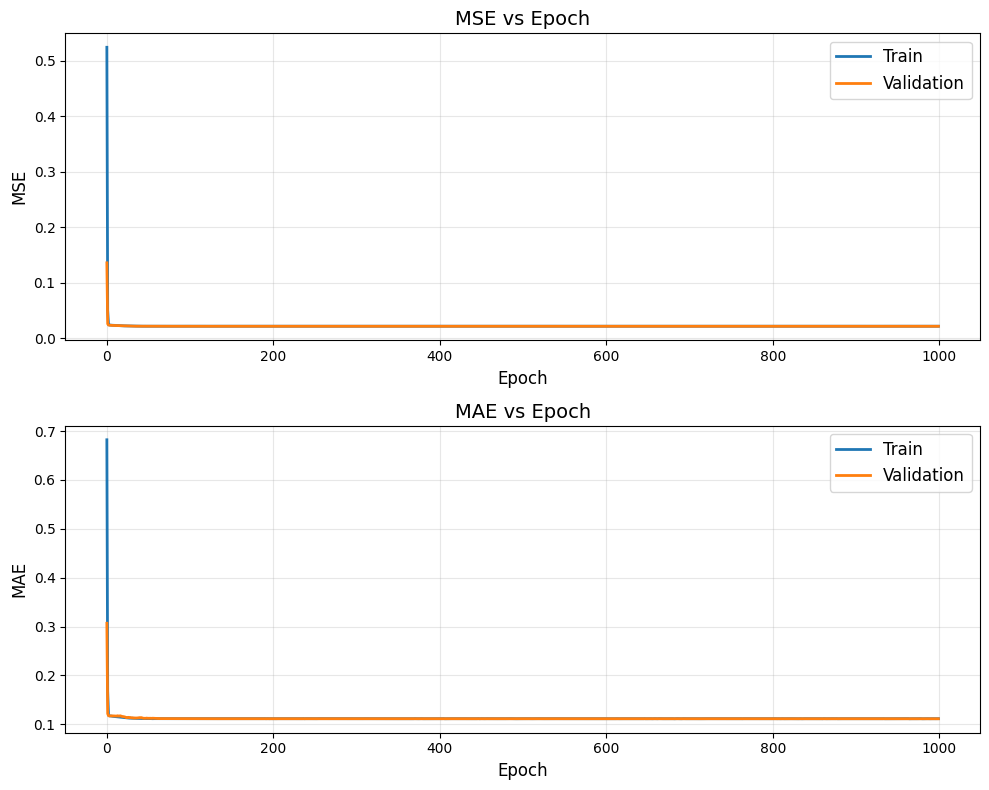

Plotting residuals...


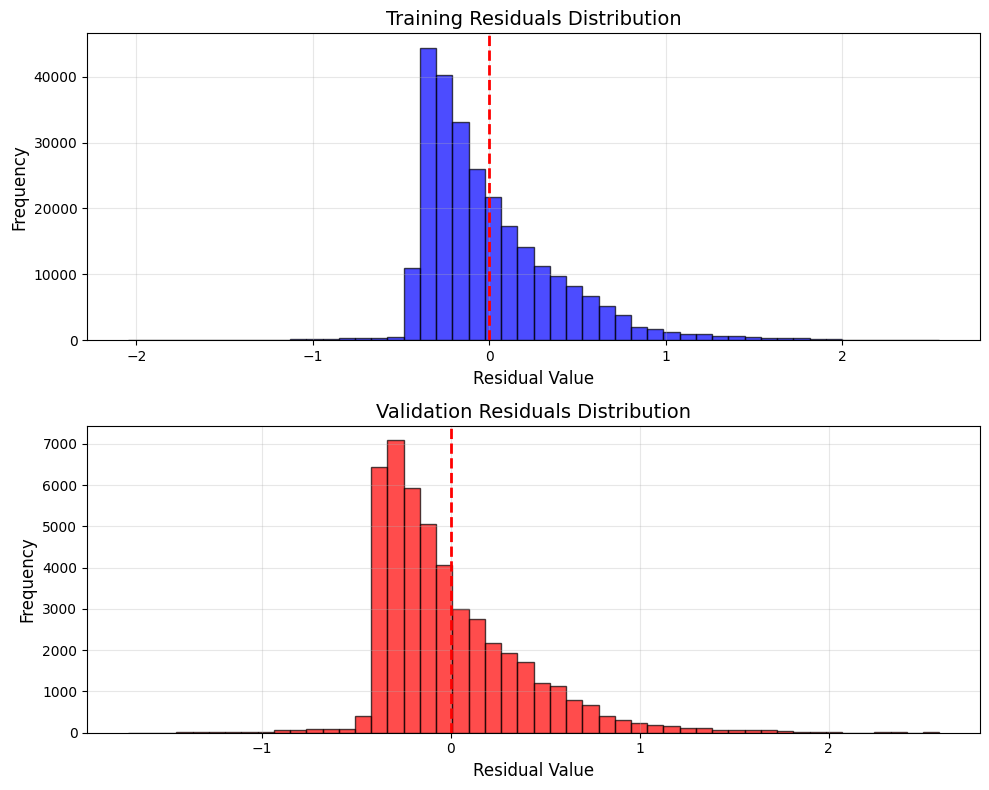

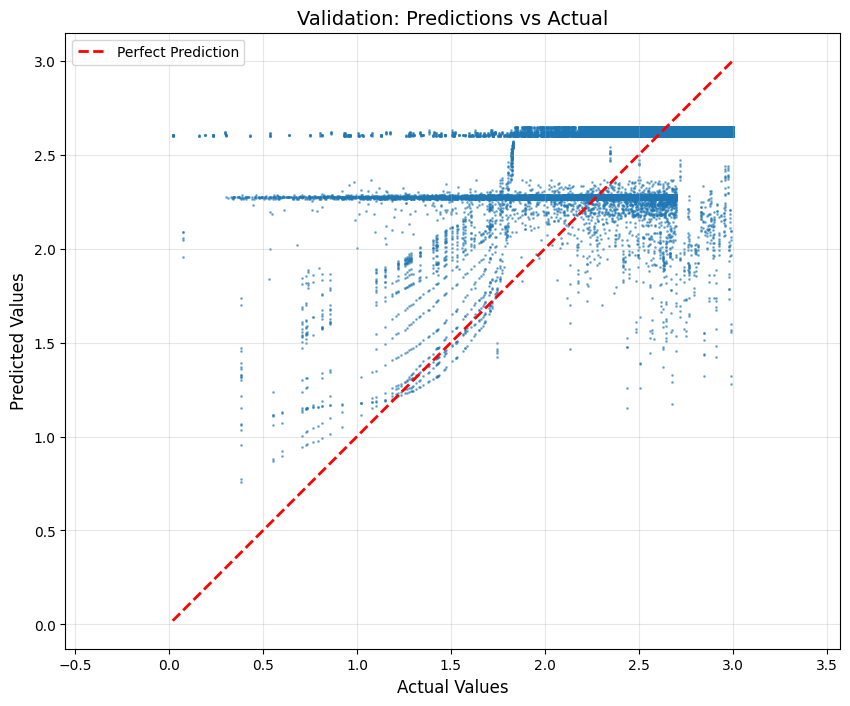


--- Training Metrics ---
R²:   0.1242
MSE:  0.1484
MAE:  0.2933
RMSE: 0.3852

--- Validation Metrics ---
R²:   0.1242
MSE:  0.1505
MAE:  0.2941
RMSE: 0.3880

--- Test Metrics ---
R²:   0.1440
MSE:  0.1472
MAE:  0.2920
RMSE: 0.3836


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.random import set_seed
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import joblib
import pickle

def set_seeds(seed_value=0):
    """Set seeds for reproducibility"""
    seed(seed_value)
    set_seed(seed_value)

def load_and_preprocess_data(filepath):
    """Load and preprocess the geoelectric data"""
    df = pd.read_csv(filepath)
    
    # Extract features and targets
    X_raw = df[[f'dBzdt_{i}' for i in range(1, 41)]].values
    y_raw = df[[f'rho_{i}' for i in range(1, 21)] + [f'thk_{i}' for i in range(1, 20)]].values
    
    # Apply log scaling with clipping
    X = np.log10(np.clip(X_raw, 1e-8, None))
    y = np.log10(np.clip(y_raw, 1e-8, None))
    
    return X, y

def split_and_normalize_data(X, y, test_size=0.2, val_size=0.15, random_state=42):
    """Split data into train/val/test and normalize"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=random_state
    )
    
    # Initialize scalers
    scaler_in = MinMaxScaler()
    scaler_out = MinMaxScaler()
    
    # Fit and transform data
    X_train_norm = scaler_in.fit_transform(X_train)
    X_val_norm = scaler_in.transform(X_val)
    X_test_norm = scaler_in.transform(X_test)
    
    y_train_norm = scaler_out.fit_transform(y_train)
    y_val_norm = scaler_out.transform(y_val)
    y_test_norm = scaler_out.transform(y_test)
    
    # Reshape for Conv1D: (samples, time steps, features)
    X_train_norm = X_train_norm.reshape((X_train_norm.shape[0], X_train_norm.shape[1], 1))
    X_val_norm = X_val_norm.reshape((X_val_norm.shape[0], X_val_norm.shape[1], 1))
    X_test_norm = X_test_norm.reshape((X_test_norm.shape[0], X_test_norm.shape[1], 1))
    
    return (X_train_norm, X_val_norm, X_test_norm, 
            y_train_norm, y_val_norm, y_test_norm,
            y_train, y_val, y_test, scaler_in, scaler_out)

def build_cnn_model(input_shape, output_dim, leaky_relu_alpha=0.01):
    """Build the CNN model architecture"""
    model = keras.Sequential([
        # Encoder layers
        keras.layers.Conv1D(6, 2, strides=1, padding='same', input_shape=input_shape),
        keras.layers.LeakyReLU(leaky_relu_alpha),
        keras.layers.MaxPooling1D(pool_size=2, strides=1),
        
        keras.layers.Conv1D(12, 2, strides=1, padding='same'),
        keras.layers.LeakyReLU(leaky_relu_alpha),
        keras.layers.MaxPooling1D(pool_size=2, strides=1),
        
        keras.layers.Conv1D(24, 2, strides=1, padding='same'),
        keras.layers.LeakyReLU(leaky_relu_alpha),
        keras.layers.MaxPooling1D(pool_size=2, strides=1),
        
        keras.layers.Conv1D(48, 2, strides=1, padding='same'),
        keras.layers.LeakyReLU(leaky_relu_alpha),
        keras.layers.MaxPooling1D(pool_size=2, strides=1),
        
        # Decoder layers
        keras.layers.Conv1D(24, 2, strides=1, padding='same'),
        keras.layers.LeakyReLU(leaky_relu_alpha),
        keras.layers.Dropout(0.02),
        
        keras.layers.Conv1D(12, 2, strides=1, padding='same'),
        keras.layers.LeakyReLU(leaky_relu_alpha),
        keras.layers.Dropout(0.01),
        
        keras.layers.Conv1D(6, 2, strides=1, padding='same'),
        keras.layers.LeakyReLU(leaky_relu_alpha),
        
        # Output layer
        keras.layers.Flatten(),
        keras.layers.Dense(output_dim)
    ])
    
    return model

def create_epoch_logger(print_every=50):
    """Create a simple epoch logging function"""
    def on_epoch_end(epoch, logs=None):
        if epoch % print_every == 0:
            loss = logs.get('loss', 0)
            val_loss = logs.get('val_loss', 0)
            print(f"Epoch {epoch}: loss={loss:.4f}, val_loss={val_loss:.4f}")
    
    return keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

def train_model(model, X_train, y_train, X_val, y_val, 
                learning_rate=5e-5, epochs=1000, verbose=0, print_every=50):
    """Train the model and print R² at intervals"""

    class R2Logger(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if epoch % print_every == 0 or epoch == epochs - 1:
                y_train_pred = self.model.predict(X_train, verbose=0)
                y_val_pred = self.model.predict(X_val, verbose=0)
                r2_train = r2_score(scaler_out.inverse_transform(y_train), scaler_out.inverse_transform(y_train_pred))
                r2_val = r2_score(scaler_out.inverse_transform(y_val), scaler_out.inverse_transform(y_val_pred))
                print(f"Epoch {epoch:04d} - R² Train: {r2_train:.4f} | R² Val: {r2_val:.4f}")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )

    # Learning rate scheduler (optional, kept)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        verbose=verbose,
        callbacks=[R2Logger(), reduce_lr]
    )

    return history

def save_model_and_scalers(model, scaler_in, scaler_out, history):
    """Save the trained model, scalers, and training history"""
    model.save('cnn_model.h5')
    joblib.dump(scaler_in, 'scaler_in.pkl')
    joblib.dump(scaler_out, 'scaler_out.pkl')
    
    with open('tr_history.pickle', 'wb') as f:
        pickle.dump(pd.DataFrame(history.history), f)

def make_predictions(model, X_train, X_val, X_test, scaler_out):
    """Make predictions and inverse transform"""
    y_train_pred_norm = model.predict(X_train, verbose=0)
    y_val_pred_norm = model.predict(X_val, verbose=0)
    y_test_pred_norm = model.predict(X_test, verbose=0)
    
    y_train_pred = scaler_out.inverse_transform(y_train_pred_norm)
    y_val_pred = scaler_out.inverse_transform(y_val_pred_norm)
    y_test_pred = scaler_out.inverse_transform(y_test_pred_norm)
    
    return y_train_pred, y_val_pred, y_test_pred

def plot_training_history(history, metrics=['mean_squared_error', 'mean_absolute_error'], 
                         labels=['MSE', 'MAE']):
    """Plot training history"""
    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = hist_df.index
    
    fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 4*len(metrics)))
    if len(metrics) == 1: 
        axs = [axs]
    
    for i, metric in enumerate(metrics):
        axs[i].plot(hist_df['epoch'], hist_df[metric], label='Train', linewidth=2)
        axs[i].plot(hist_df['epoch'], hist_df['val_' + metric], label='Validation', linewidth=2)
        axs[i].set_title(f'{labels[i]} vs Epoch', fontsize=14)
        axs[i].set_xlabel('Epoch', fontsize=12)
        axs[i].set_ylabel(labels[i], fontsize=12)
        axs[i].grid(True, alpha=0.3)
        axs[i].legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true_train, y_pred_train, y_true_val, y_pred_val, nbins=50):
    """Plot residual histograms"""
    error_train = y_pred_train.ravel() - y_true_train.ravel()
    error_val = y_pred_val.ravel() - y_true_val.ravel()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    ax1.hist(error_train, bins=nbins, color='blue', alpha=0.7, edgecolor='black')
    ax1.set_title('Training Residuals Distribution', fontsize=14)
    ax1.set_xlabel('Residual Value', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.axvline(0, color='red', linestyle='--', linewidth=2)
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(error_val, bins=nbins, color='red', alpha=0.7, edgecolor='black')
    ax2.set_title('Validation Residuals Distribution', fontsize=14)
    ax2.set_xlabel('Residual Value', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.axvline(0, color='red', linestyle='--', linewidth=2)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(y_true, y_pred, title="Predictions vs Actual"):
    """Plot predictions vs actual values"""
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true.ravel(), y_pred.ravel(), alpha=0.5, s=1)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axis('equal')
    plt.show()

def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate and print performance metrics"""
    r2 = r2_score(y_true, y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)
    
    print(f"\n--- {dataset_name} Metrics ---")
    print(f"R²:   {r2:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    return r2, mse, mae, rmse

def main():
    """Main execution function"""
    # Set seeds for reproducibility
    set_seeds(0)
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y = load_and_preprocess_data("/kaggle/input/geoelectric-models/geoelectric_models.csv")
    
    # Split and normalize data
    print("Splitting and normalizing data...")
    (X_train_norm, X_val_norm, X_test_norm, 
     y_train_norm, y_val_norm, y_test_norm,
     y_train, y_val, y_test, scaler_in, scaler_out) = split_and_normalize_data(X, y)
    
    # Build model
    print("Building CNN model...")
    model = build_cnn_model(
        input_shape=(X_train_norm.shape[1], 1),
        output_dim=y.shape[1]
    )
    
    print(f"Model summary:")
    model.summary()
    
    # Train model
    print("\nTraining model...")
    history = train_model(
        model, X_train_norm, y_train_norm, X_val_norm, y_val_norm,
        learning_rate=5e-5, epochs=1000, verbose=0, print_every=50
    )
    
    # Save model and scalers
    print("Saving model and scalers...")
    save_model_and_scalers(model, scaler_in, scaler_out, history)
    
    # Make predictions
    print("Making predictions...")
    y_train_pred, y_val_pred, y_test_pred = make_predictions(
        model, X_train_norm, X_val_norm, X_test_norm, scaler_out
    )
    
    # Plot training history
    print("Plotting training history...")
    plot_training_history(history)
    
    # Plot residuals
    print("Plotting residuals...")
    plot_residuals(y_train, y_train_pred, y_val, y_val_pred)
    
    # Plot predictions vs actual
    plot_predictions_vs_actual(y_val, y_val_pred, "Validation: Predictions vs Actual")
    
    # Calculate and print metrics
    calculate_metrics(y_train, y_train_pred, "Training")
    calculate_metrics(y_val, y_val_pred, "Validation")
    calculate_metrics(y_test, y_test_pred, "Test")
    
    return model, history, scaler_in, scaler_out

if __name__ == "__main__":
    model, history, scaler_in, scaler_out = main()

In [24]:
def predict_and_print(model, X_new, y_true_log):
    # Normalize and reshape input
    X_norm = scaler_in.transform(X_new)
    X_input = X_norm.reshape((X_norm.shape[0], X_norm.shape[1], 1))

    # Predict (normalized)
    y_pred_norm = model.predict(X_input)

    # Inverse transform predictions
    y_pred_log = scaler_out.inverse_transform(y_pred_norm)

    # Convert both prediction and truth back to real scale
    y_pred_real = 10 ** y_pred_log
    y_true_real = 10 ** y_true_log

    print("\n--- Predictions ---")
    for i, pred in enumerate(y_pred_real):
        print(f"Sample {i + 1:02}: Predicted = {pred}")

    print("\n--- Actual Values ---")
    for i, real in enumerate(y_true_real):
        print(f"Sample {i + 1:02}: Actual    = {real}")
X_sample = X[:1]
y_sample = y[:1]

predict_and_print(model, X_sample, y_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

--- Predictions ---
Sample 01: Predicted = [446.0385  449.717   441.2026  446.68958 432.19144 422.28723 420.77496
 415.33035 416.62082 412.719   403.107   407.88034 404.23364 405.38147
 401.92834 405.59653 404.46762 408.9067  404.0941  404.45496 187.04042
 189.80554 187.57327 187.33359 189.58923 185.37509 189.13112 186.87927
 184.01399 185.91269 189.89058 193.32808 186.39464 184.78964 189.40355
 188.3697  188.05167 184.2291  187.3447 ]

--- Actual Values ---
Sample 01: Actual    = [446.343  446.343  446.343  446.343  446.343  446.343  446.343  446.343
 446.343  446.343  509.278  509.278  509.278  509.278  509.278  509.278
 509.278  509.278  509.278  509.278  266.184  430.139  339.507  403.307
 266.559  478.036   35.2051 271.676  142.267  241.488  343.062  105.713
 304.864  164.436  440.662   68.4305  52.9991 479.64    78.1452]
